# GAN(Generative Adversarial Networks)

## GAN이란?

2016년 Ian Goodfellow에 의해 개발된 <font color="ff6f61">**GAN(Generative Adversarial Networks, 생성적 적대 신경망)**</font>은 실제와 유사한 데이터를 만들어내는 생성모델입니다.<br/>

**생성자(Generator)**는 실제와 동일한 데이터를 만들기 위해 노력하고<br/>

**판별자(Discriminator)**는 생성된 데이터가 진짜인지 아닌지를 판단하는데요.<br/>

처음에는 서로의 성능이 그렇게 좋지 않지만 학습을 거듭하면서 점점 발전하게 됩니다.

고양이 그림을 그리는 GAN, 즉 AI 화가에 적용해보겠습니다.

### 그림을 그리는 GAN이라면?

<img src="https://tensorflow.org/tutorials/generative/images/gan1.png" height="350"/>

아래는 고양이 그림을 그리는 GAN 모델에서 생성자와 판별자의 역할을 나타낸 것입니다.<br/>
생성자는 Random Noise 로부터 실제 고양이 그림과 유사한 그림을 생성합니다.<br/>
판별자는 생성자가 만들어낸 고양이 그림과 실제 고양이 사진을 임의로 입력받으면서 둘을 Fake/Real 로 구분하는 **이진 분류**를 수행합니다.

학습을 잘 마친 GAN 모델에서 생성자는 실제와 유사한 이미지를 생성하게 되어<br/>
판별자가 실제(Real)와 가짜(Fake)를 잘 구분해내지 못하게 됩니다. **(Accuracy $\approx$ 0.5)**

<img src="https://tensorflow.org/tutorials/generative/images/gan2.png" height="400"/>

예제를 통해 GAN이 어떻게 학습되는지 자세히 알아보도록 하겠습니다.

### Example

GAN을 통해서 MNIST 손글씨 데이터를 생성하는 예제를 해보겠습니다.<br/>
아래는 GAN 모델이 MNIST 손글씨 데이터 50에포크 동안 학습하면서 생성자가 매 에포크마다 생성한 손글씨 이미지를 gif 로 이어붙인 것입니다.<br/>
처음에 Noise 형태에서 시작해서 학습이 진행되면서 실제 손글씨 이미지와 닮아가는 것을 볼 수 있습니다.

<img src="https://i.imgur.com/i5Zs6SY.gif">

예제에 사용할 모델은 Convolution Layer 로 이루어진 **DCGAN(Deep Convolution GAN)**입니다.<br/>

1. **필요한 라이브러리를 Import 하여줍니다.**

In [1]:
from tensorflow.keras import layers
from IPython import display

import glob
import imageio
import os
import PIL
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2. **데이터셋을 불러온 뒤 정규화 하여줍니다.**

    본 예제에서는 Test 데이터셋은 사용하지 않기 때문에 `_` 로 처리하여줍니다.<br/>
    본 예제에서는 이미지를 \[-1, 1\] 의 범위로 정규화하도록 하겠습니다.

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

3. **모델 구축하기 - 생성자(Generator)**

    먼저 **생성자(Generator)**를 구축합니다.<br/>
생성자는 Random Noise 로부터 이미지를 생성하기 위해서 Transpose Convolution 을 사용하여 Upsampling 을 수행합니다.<br/>
첫 Dense 층은 Random Noise 를 입력받으며 원하는 이미지 사이즈인 28X28 이 나오도록 **`Conv2DTranspose`**를 겹겹이 쌓습니다.<br/>

    은닉층의 활성화 함수는 ReLU 함수의 변형인 LeakyReLU 함수를 사용하며<br/>
활성화 함수 이전에 배치 정규화(Batch Normalization)을 적용합니다.

In [6]:
def make_generator_model():
    """
    모델을 구축하는 함수입니다.
    """
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

아직 훈련을 진행하지 않은 생성자를 이용해 이미지를 생성해봅시다.

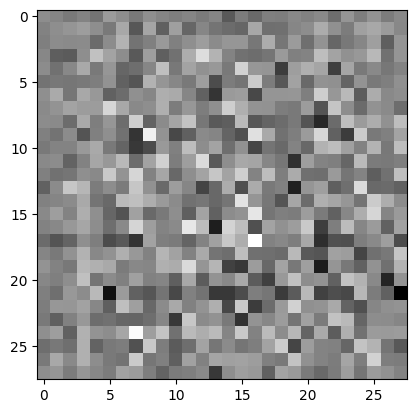

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

4. **모델 구축하기 - 판별자(Discriminator)**

    다음으로 **판별자(Discriminator)**를 구축해보겠습니다.<br/>
합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기이며<br/>
은닉층의 활성화 함수는 ReLU 함수의 변형인 LeakyReLU 함수를 사용하고 드롭아웃(Dropout)을 적용합니다.

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

아직 훈련을 진행하지 않은 생성자를 이용해 이미지가 진짜인지 가짜인지 판별합니다.<br/>
실제(Real) 이미지에는 양수(Positive)를, 가짜(Fake) 이미지에는 음수(Negative)를 출력하도록 훈련됩니다.

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00158029]], shape=(1, 1), dtype=float32)


5. **손실 함수(Loss function)와 옵티마이저(Optimizer) 정의하기**

    생성자와 판별자의 손실 함수를 정의합니다.

    판별자의 손실함수는 **`real_loss`**와 **`fake_loss`**를 더한 값입니다.<br/>
    **`real_loss`**의 경우 전체가 1인 행렬과 **`real_output`**을 비교하여 구하며<br/>
    **`fake_loss`**의 경우 전체가 0인 행렬과 **`fake_output`**을 비교하여 구합니다.

    생성자의 손실 함수는 전체가 1인 행렬과 **`fake_output`**을 비교하여 구합니다.

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    """
    
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

옵티마이저(Optimizer)는 모두 Adam 을 사용하였습니다.

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

6. **모델이 저장되는 Checkpoint 를 설정합니다.**


In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

7. **훈련 루프를 지정합니다.**

    1. 생성자가 입력으로 Random Noise 를 입력받습니다.
    2. 입력받은 Random Noise 를 사용하여 이미지를 생성합니다.
    3. 판별자를 사용하여 Train 데이터셋의 진짜 이미지와 생성자가 만들어낸 가짜 이미지를 분류합니다.
    4. 각 모델의 손실을 계산하고, 경사 하강법과 역전파를 통해 가중치를 업데이트합니다.

In [15]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Iteration 마다 어떻게 각 모델이 갱신되는 지에 대한 함수를 정의합니다.

In [16]:
@tf.function
def train_step(images):
    """
    위에서 정의한 손실함수를 바탕으로
    Iteration(=step) 마다 가중치를 갱신합니다.

    Args:
        images: 훈련 데이터셋에 있는 실제 이미지입니다.
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

중간 결과를 확인하기 위해 생성된 이미지를 출력하고 저장하는 함수를 정의합니다.

In [17]:
def generate_and_save_images(model, epoch, test_input):
    """
    모델이 이미지를 생성한 후 저장하는 함수입니다.
    
    Args:
        model: 이미지를 생성할 모델입니다.
        epoch: 진행 중인 Epoch 숫자입니다.
        test_input: model에 입력되는 데이터입니다.
    """

    # training=False 이면 모든 층이 추론(inference)모드로 진행됩니다.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [18]:
def train(dataset, epochs):
    """
    학습 중 실행할 동작을 함수로 정의합니다.
    
    Args:
        dataset: (훈련) 데이터셋입니다.
        epochs: 최종 학습 Epoch 입니다.
    """
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 이미지를 생성한 뒤 저장합니다.(추후에 만들 GIF를 위함입니다.)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # 15 에포크가 지날 때마다 모델을 Checkpoint에 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        # Epoch 마다 소요 시간을 출력합니다.
        print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')

    # 마지막 에포크가 끝난 후 이미지를 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

7. **함수를 실행시켜 실제 훈련을 진행합니다.**

    초반에는 Random Noise 처럼 보이는 이미지가 생성되는 것을 볼 수 있습니다.<br/>
    하지만 학습이 진행될수록 점점 손글씨와 유사한 이미지가 생성됩니다.

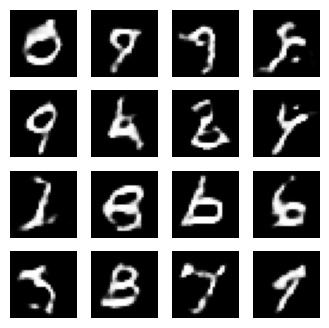

CPU times: user 2min 23s, sys: 28.4 s, total: 2min 52s
Wall time: 9min 26s


In [19]:
%%time
train(train_dataset, EPOCHS)

마지막 Checkpoint 를 복구합니다.

In [20]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

8. **GIF를 생성합니다.**

In [21]:
def display_image(epoch_no):
    """
    특정 Epoch에 생성된 이미지를 불러오는 함수입니다.

    Args:
        epoch_no: 특정 Epoch에 해당하는 숫자입니다.
    """
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

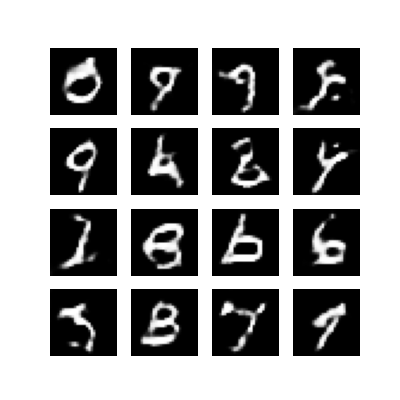

In [22]:
display_image(EPOCHS)

아래 코드를 실행하면 훈련 중에 저장된 이미지를 이어붙여 GIF 애니메이션을 만들 수 있습니다.

In [23]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
    
        image = imageio.imread(filename)
        writer.append_data(image)
    
    image = imageio.imread(filename)
    writer.append_data(image)

<ipython-input-23-0e4332d96d4d>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-23-0e4332d96d4d>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [24]:
import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

코랩에서 작업하고 있다면, 아래의 코드를 실행시켜 애니메이션을 다운로드 받을 수도 있습니다.

In [25]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## CycleGAN

**<font color="ff6f61">CycleGAN</font>**은 위에서 사용했던 DCGAN의 구조를 변경하여 만든 새로운 구조입니다.<br/>
지금까지 알아본 GAN은 학습했던 실제 이미지와 유사한 이미지를 생성자가 만들어 낼 수 있도록 학습이 되었는데요.<br/>
CycleGAN을 사용하면 특정 이미지 도메인의 특성을 다른 이미지에 적용하는 작업도 할 수 있습니다.

아래 그림처럼 과일의 색을 바꾸거나, 사진 속 계절을 변경하는 것도 가능하며<br/>
이 외에도 특정 화가의 화풍을 다른 그림에 적용하는 등의 작업도 CycleGAN을 사용하여 할 수 있습니다.

<img src="https://i.imgur.com/eb6FDYB.png" width="800"/>
<br/>
<img src="https://i.imgur.com/eCl75JG.png" width="800"/>


### CycleGAN 의 장점

기존에 위 작업과 비슷한 작업을 수행하는 **Pix2Pix** 라는 모델에서는<br/>
Train 데이터셋을 구성할 때 레이블에 해당하는 데이터를 무조건 짝지어 주어야 했습니다.

예를 들어, 흑백 사진을 컬러로 변경하는 모델을 학습하기 위해서 데이터셋을 준비해야한다면<br/>
흑백 사진 10000장과 각각에 매칭되는 컬러 사진을 10000장을 준비해야 했는데요.<br/>
하지만 이렇게 정확히 매칭되는 사진을 대량으로 구하기란 쉬운 일은 아니었습니다.

하지만 **CycleGAN은 이와 다르게 서로 변환하고 싶은 두 스타일의 이미지를 따로 구하더라도 좋은 성능**을 보인다는 장점이 있습니다.<br/>
덕분에 학습을 위한 데이터셋 마련이 훨씬 쉬워지고 그에 따라 모델의 성능이나 유용성 역시 좋아지게 되었습니다.


### CycleGAN 의 원리

그렇다면 CycleGAN은 어떻게 이렇게 특정 이미지의 스타일을 다른 이미지에 적용할 수 있는 것일까요?

아래 그림은 **갈색 말(`A`)**과 **얼룩말(`B`)**의 스타일을 서로 변환하는 CycleGAN이 학습되는 방식입니다.<br/>

<img src="https://i.imgur.com/erjAXAv.jpg">

1. 일단은 생성자를 2개 준비합니다. 각각의 생성자는 A→B, B→A 로 이미지를 변경합니다.
2. 판별자 역시 2개를 준비합니다. 각각의 판별자는 A, B 에 대해 Real/Fake 를 판단하게 됩니다.

- **사진 윗부분**
    1. A 이미지를 입력하여 A→B 생성자를 통해 B 이미지를 생성한 후 B 판별자를 통해 판별합니다.
    2. 생성된 B 이미지를 B→A 생성자를 통해 다시 A 인풋과 같은 형태로 생성할 수 있도록 합니다.

- **사진 아랫부분**
    1. B 이미지를 입력하여 B→A 생성자를 통해 A 이미지를 생성한 후 A 판별자를 통해 판별합니다.
    2. 생성된 B 이미지를 A→B 생성자를 통해 다시 A 인풋과 같은 형태로 생성할 수 있도록 합니다.

- **위와 같이 다시 돌아가는 과정(Cycle)을 거치는 이유는 무엇일까요?**

CycleGAN은 비슷한 이미지에 대해 1:1 매칭을 시켜 이미지를 학습하는 것이 아니기 때문에<br/>
A→B 혹은 B→A, 즉 이미지를 변환하면서 Input 정보가 유실되어 원본 이미지의 특성을 잃어버리게 될 수 있습니다.<br/>
이 때문에 **원본 데이터로 돌아갈 수 있을 정도로만 변환을 진행**하기 위해서<br/>
A→B→A, B→A→B 로 돌아가는 Cycle 구조를 가지게 되었고 이 때문에 CycleGAN 이라는 명칭이 붙었습니다.